In [1]:
import numpy as np
import pandas as pd
import copy
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from torchvision.transforms import v2
import torchvision
import os
from PIL import Image
import re
import matplotlib.pyplot as plt
from tqdm import tqdm
import string
import random
import nltk
from nltk.translate.bleu_score import sentence_bleu,corpus_bleu
from nltk.translate.meteor_score import meteor_score
import copy

In [2]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [3]:
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)

In [4]:
set_seed(42)

In [5]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

print("device is {}".format(device))

device is cuda


# Downloading Data

In [ ]:
import gdown
import zipfile
import os

google_drive_link = "https://drive.google.com/uc?id=1mehPj1VVwgKyqtqmq4rwkTJTA_tSMD9_"
download_path = "data.zip"
input_dir = 'flickr8k/images/'
output_file = 'flickr8k/captions.txt'

gdown.download(google_drive_link, download_path, quiet=False)

with zipfile.ZipFile(download_path, 'r') as zip_ref:
    zip_ref.extractall()

os.remove(download_path)

list_of_files = os.listdir(input_dir)
print("List of files in input directory:")
print(list_of_files)


# Preprocessing Images

In [10]:
def preprocess_images(input_dir):
  """
  input_dir : str : input_dir
  """
  preprocess = transforms.Compose([
      transforms.Resize((224,224)),
      transforms.ToTensor(),
    ]
  )
  image = []
  for img_name in list_of_files:
    img = preprocess(Image.open(os.path.join(input_dir,img_name)))
    image.append(img)
  return torch.stack(image).to(device)

In [11]:
def display_image(Images,num):
  T = transforms.ToPILImage()
  img = T(Images[num,:,:,:])
  plt.imshow(img)

In [12]:
Images = preprocess_images(input_dir)
# Images /= 255
Images.size()

torch.Size([8091, 3, 224, 224])

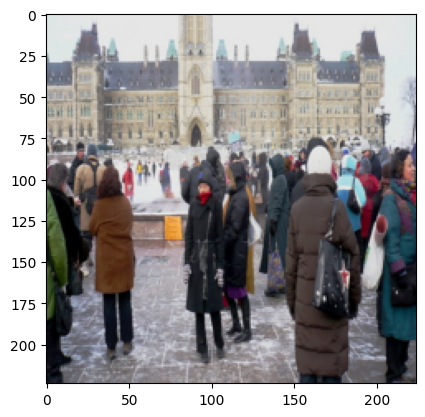

In [13]:
display_image(Images,1)

# Preprocessing Captions

In [14]:
start = "<start>"
end = "<end>"
unk = "<unk>"

In [15]:
def preprocess_text(text):
  """
  remove the digits, punctuations and change all the punctuations and all words to lower case
  this is done to make all captions contain <start>, <end>, and words in lower case
  """
  text = re.sub(r'\d+', '', text)
  text = " ".join([i.strip(string.punctuation).lower() for i in text.split()])
  text = " ".join([i for i in text.split() if len(i) > 1])
  text = text.replace('\s+', ' ').replace('\n','')
  return text


In [16]:
def preprocess_caption(output_dir):
  captions = open(output_dir, 'r').read().strip().split('\n')
  caption_dict = {}
  for row in captions[1:]:
      img_id, caption = row.split(',')[0],row.split(',')[1]
      caption = '<start> ' + preprocess_text(caption.strip()) + ' <end>'
      if img_id in caption_dict:
          caption_dict[img_id].append(caption)
      else:
          caption_dict[img_id] = [caption]

  return caption_dict

In [17]:
def tokenise_captions(captions_set):
  int_to_word = {}
  word_to_int = {}
  total_words = []
  for captions in captions_set:
    for caption in captions:
      total_words += list(filter(None,caption.split(" ")))
  unique_words = list(set(total_words))
  word_to_int = dict([(words,index+3) for index,words in enumerate(unique_words)])
  int_to_word = dict([(index+3,words) for index,words in enumerate(unique_words)])
  word_to_int[start] = 0
  word_to_int[end] = 1
  word_to_int[unk] = 2
  int_to_word[0] = start
  int_to_word[1] = end
  int_to_word[2] = unk
  return int_to_word,word_to_int

In [18]:
def encoding_captions(int_to_word, word_to_int,captions_set):
  encoded_captions = []
  for index,captions in enumerate(captions_set):
    for ind,caption in enumerate(captions):
      seq = []
      text = list(filter(None,caption.split(" ")))
      for word in text:
        if word in word_to_int.keys():
          seq.append(word_to_int[word])
        else:
          seq.append(word_to_int["<unk>"])
      encoded_captions.append((torch.tensor(seq)))
  return encoded_captions

In [19]:
caption_dict = preprocess_caption(output_file)

# Train-Validation split

In [20]:
train_split = int(0.8*len(list_of_files))
val_split = (len(list_of_files) - train_split)

train_files = list_of_files[:train_split]
validation_files = list_of_files[train_split:]


train_images = Images[:train_split,:,:,:]
validation_images = Images[train_split:,:,:,:]

In [21]:
train_captions = [caption_dict[file] for file in train_files]
vocab = tokenise_captions(train_captions)
encoded_train_captions = encoding_captions(vocab[0],vocab[1],train_captions)

In [22]:
val_captions = [caption_dict[file] for file in validation_files]
encoded_val_captions = encoding_captions(vocab[0],vocab[1],val_captions)

['<start> two men are wrestling in competition <end>', '<start> two men are wrestling while other people are watching <end>', '<start> two men wrestle on the floor in front of an group of young men <end>', '<start> two men wrestling at match <end>', '<start> two young men competing in wrestling tournament <end>']


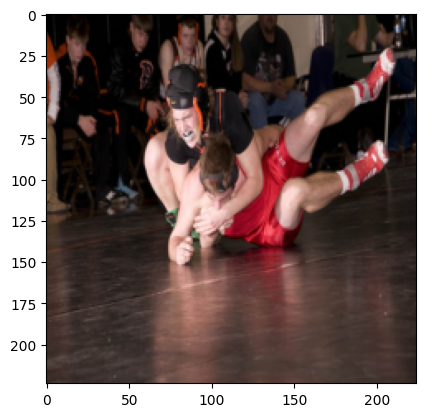

In [23]:
print(train_captions[0])
display_image(train_images,0)

In [24]:
print(train_images.shape)
print(len(vocab[0]))
print(len(train_files))
print((len(train_captions)))

torch.Size([6472, 3, 224, 224])
7804
6472
6472


# Captions Dataset

In [25]:
class CaptionDataset(Dataset):
  def __init__(self,images,encoded_captions,split,captions_per_images):
    self.images = images
    self.captions = encoded_captions
    self.captions_per_images = captions_per_images
    self.split = split # "train","val" or "test"
    self.dataset_size = len(encoded_captions)

  def __len__(self):
    return self.dataset_size

  def get_train_indices(self):
    indices = []
    randomised_captions = np.random.choice(list(range(5)),len(self.images),replace = True)
    indices = randomised_captions + np.array(list(range(len(self.images))))*5
    return list(indices)

  def __getitem__(self,index):
    # print("index:",index//self.captions_per_images)
    img = self.images[(index//self.captions_per_images),:,:,:]
    caption = self.captions[index]
    # print(type(caption))
    caplen = len(caption)
    if self.split == "train":
      return img,caption,caplen
    else :
      return img,self.captions[(index // self.captions_per_images)*self.captions_per_images:((index // self.captions_per_images) + 1)*self.captions_per_images-1]


In [26]:
train_dataset = CaptionDataset(train_images,encoded_train_captions,"train",5)
train_loader = DataLoader(train_dataset,shuffle = True)

In [27]:
validation_captions = []
for caption_set in val_captions:
  for captions in caption_set:
    validation_captions.append(captions)
val_dataset = CaptionDataset(validation_images,validation_captions,"val",5)
val_loader = DataLoader(val_dataset)

# CNN encoder part of the model

In [28]:
class CNN_model_1(nn.Module):
    #vgg 19
    def __init__(self, embed_size):
        super(CNN_model_1, self).__init__()
        vgg = models.vgg19(pretrained=True)
        for param in vgg.parameters():
            param.requires_grad_(False)

        modules = list(vgg.children())[:-1]
        self.vgg = nn.Sequential(*modules)
        self.embed = nn.Linear(25088, embed_size)
        self.embed.weight.data.normal_(0.0, 0.02)
        self.embed.bias.data.fill_(0)

    def forward(self, images):
        features = self.vgg(images)
        features = features.reshape(features.size(0), -1)
        return self.embed(features)


In [29]:
from torchvision.models.resnet import resnet152
class CNN_model_2(nn.Module):
  # ResNet model
  def __init__(self,embed_size):
    super(CNN_model_2,self).__init__()
    resnet = models.resnet152(pretrained = True)
    for param in resnet.parameters():
      param.requires_grad_(False)
    modules = list(resnet.children())[:-1]
    self.resnet = nn.Sequential(*modules)
    self.linear = nn.Linear(resnet.fc.in_features,embed_size)
    self.linear.weight.data.normal_(0.0, 0.02)
    self.linear.bias.data.fill_(0)

  def forward(self, images):
    features = self.resnet(images)
    features = features.reshape(features.size(0), -1)
    return self.linear(features)

# LSTM and Transformer part of the decoder

In [30]:
class LSTM_model_1(nn.Module):
  def __init__(self,embed_dim,hidden_dim,vocab_size,n_layers = 20):
    """
    embed_size : int : size of embedding
    hidden_dim : int : dimension of hidden layer in lstm
    vocab_size : int : size of vocabulary
    n_layers : int : number of layers
    """
    super(LSTM_model_1,self).__init__()
    self.embed_dim = embed_dim
    self.hidden_dim = hidden_dim
    self.vocab_size = vocab_size
    self.n_layers = n_layers
    self.embeddings = nn.Embedding(vocab_size,embed_dim)
    self.lstm = nn.LSTM(input_size = embed_dim,hidden_size = hidden_dim,num_layers = n_layers,batch_first = True)
    self.linear = nn.Linear(hidden_dim,vocab_size)
    self.dropout = nn.Dropout(p=0.4)
    self.softmax = nn.Softmax()

  def forward(self,features,captions):
    """
    X : tensor : input
    """
    captions = captions[:,:-1]
    embeddings = self.embeddings(captions)
    inputs = torch.cat((features.unsqueeze(1),embeddings),1)
    hidden = torch.randn(self.n_layers,len(inputs),self.hidden_dim).to(device)
    carry = torch.randn(self.n_layers,len(inputs),self.hidden_dim).to(device)
    output, (hidden,carry) = self.lstm(inputs,(hidden,carry))
    return self.linear(self.dropout(output[0]))
    # return self.linear(output)

  def sample(self,X,states = None,max_len = 20):
    """
    Greedy Search
    X : tensor : input
    States : (tensor,tensor) :
    """
    predicted_caption = []
    inputs = X
    for i in range(max_len):
      output, states = self.lstm(inputs,states)
      output = output.squeeze(1).squeeze(1)
      # output = self.softmax(self.linear(output))
      output = self.linear(output)
      target = output.max(1)[1]
      predicted_caption.append(target.item())
      inputs = self.embeddings(target).unsqueeze(1)
    return predicted_caption


# Integrating the 2 parts of the model

In [31]:
class Model(nn.Module):
  def __init__(self,encoder,decoder,embed_size,hidden_size,vocab_size):
    """
    takes input for all the classes and creates the model
    """
    super(Model,self).__init__()
    self.embed_size = embed_size
    self.hidden_size = hidden_size
    self.vocab_size = vocab_size
    self.encoder = encoder
    self.decoder = decoder

  def forward(self,images,captions):
    features = self.encoder(images)
    outputs = self.decoder(features,captions)
    return features,outputs

  def evaluate_and_sample(self,image):
    features = self.encoder(image).unsqueeze(1)
    prediction = self.decoder.sample(features)
    return prediction


In [32]:
def generate_captions(model,image):
  model.eval()
  predicted_captions = model.evaluate_and_sample(image)
  sentence = ""
  for idx in predicted_captions:
    word = vocab[0][idx]
    if word != "<end>" and word != '<start>':
      sentence += vocab[0][idx] + " "
    elif word == '<end>':
      break
  return sentence

In [33]:
def validate(model):
  actual_captions = []
  generated_captions = []
  total_meteor_score = 0
  for data in tqdm(val_loader):
    image, caption_set = data
    # print(image,caption_set)
    actual_captions.append([caption[0].split() for caption in caption_set])
    generated_captions.append(generate_captions(model,image).split())
    total_meteor_score += round(meteor_score(actual_captions[-1],generated_captions[-1]),4)
  bleu1 = corpus_bleu(actual_captions, generated_captions, weights=(1.0, 0, 0, 0))
  bleu2 = corpus_bleu(actual_captions, generated_captions, weights=(0.5, 0.5, 0, 0))
  bleu3 = corpus_bleu(actual_captions, generated_captions, weights=(1/3, 1/3, 1/3, 0))
  bleu4 = corpus_bleu(actual_captions, generated_captions, weights=(0.25, 0.25, 0.25, 0.25))
  # bleu = (bleu1*bleu2*bleu3*bleu4)**0.25
  total_meteor_score /= len(generated_captions)
  print(f'BLEU-1: {bleu1}')
  print(f'BLEU-2: {bleu2}')
  print(f'BLEU-3: {bleu3}')
  print(f'BLEU-4: {bleu4}')
  # print(f'BLEU:{(bleu1*bleu2*bleu3*bleu4)**0.25}')
  print(f"meteor-score:{total_meteor_score}")
  return total_meteor_score

In [34]:
def train(model,lossfn,optimizer,train_loader,validation_loader = None,num_epochs = 30):
      model.train()
      best_checkpoint_model,best_bleu = None,0
      for epoch in range(1, num_epochs+1):
            model.train()
            average_loss = 0
            count = 0
            average_perp = 0
            indices = train_loader.dataset.get_train_indices()
            new_sampler = torch.utils.data.sampler.SubsetRandomSampler(indices=indices)
            train_loader.batch_sampler.sampler = new_sampler
            for (img,cap,caplen) in tqdm(train_loader):
                img = img.to(device)
                cap = cap.to(device)
                model.zero_grad()
                features,outputs = model(img,cap)
                loss = lossfn(outputs.view(-1, model.vocab_size), cap.view(-1))
                loss.backward()
                optimizer.step()
                count += 1
                average_loss += loss.item()
            average_loss = average_loss/count
            average_perp = np.exp(average_loss)
            print('Epoch [%d/%d], Loss: %.4f, Perplexity: %5.4f' % (epoch,num_epochs,average_loss, average_perp))
            bleu = validate(model)
            if bleu > best_bleu:
              print("checkpointing best model")
              best_checkpoint_model = copy.copy(model)
              best_bleu = bleu
      return model,best_checkpoint_model

# Calling Functions

In [35]:
learning_rate = 0.0001
num_epochs = 10
embed_size=512
hidden_size=512
vocab_size=len(vocab[0])
print(vocab_size)
n_layers=2

7804


In [36]:
decoder = LSTM_model_1(embed_size,hidden_size,vocab_size,n_layers)
# decoder = Transformer_model_1(embed_size,hidden_size,vocab_size,n_layers)
encoder = CNN_model_1(embed_size=embed_size)
model = Model(encoder,decoder,embed_size,hidden_size,vocab_size)
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:04<00:00, 116MB/s]


In [37]:
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
loss_fn = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()

Val_dataset consist of 1619 images each with 5 captions, making 8095 captions. and the len of the caption_dataset is defined to be number of captions so, it shows up as 8095 but runs for 1619 images.

Whereas in train, we have restricted the indices so that we run on each image once, so it runs for 6472 images

In [38]:
final_model,best_checkpoint_model = train(model,loss_fn,optimizer,train_loader,val_loader,num_epochs = 10)

100%|██████████| 6472/6472 [02:14<00:00, 48.24it/s]


Epoch [1/10], Loss: 4.6783, Perplexity: 107.5878


100%|██████████| 8095/8095 [02:48<00:00, 48.08it/s]


BLEU-1: 0.31931948422396395
BLEU-2: 0.16109662603025765
BLEU-3: 0.0791761772616329
BLEU-4: 0.04301984417099922
meteor-score:0.15227788758492986
checkpointing best model


100%|██████████| 6472/6472 [02:12<00:00, 48.76it/s]


Epoch [2/10], Loss: 4.0575, Perplexity: 57.8322


100%|██████████| 8095/8095 [02:49<00:00, 47.73it/s]


BLEU-1: 0.3421234299854631
BLEU-2: 0.1896323639829503
BLEU-3: 0.09613738222982968
BLEU-4: 0.04577065337866899
meteor-score:0.1767120444718973
checkpointing best model


100%|██████████| 6472/6472 [02:12<00:00, 48.80it/s]


Epoch [3/10], Loss: 3.8389, Perplexity: 46.4764


100%|██████████| 8095/8095 [02:50<00:00, 47.42it/s]


BLEU-1: 0.3502116426936519
BLEU-2: 0.1836411379230289
BLEU-3: 0.10052214773716173
BLEU-4: 0.05520067524263325
meteor-score:0.17663353922174044


100%|██████████| 6472/6472 [02:12<00:00, 48.78it/s]


Epoch [4/10], Loss: 3.7220, Perplexity: 41.3453


100%|██████████| 8095/8095 [02:50<00:00, 47.56it/s]


BLEU-1: 0.30981627986056287
BLEU-2: 0.1514781693382003
BLEU-3: 0.0700545608844111
BLEU-4: 0.03346756328123137
meteor-score:0.16424762198888196


100%|██████████| 6472/6472 [02:12<00:00, 48.82it/s]


Epoch [5/10], Loss: 3.6291, Perplexity: 37.6802


100%|██████████| 8095/8095 [02:48<00:00, 48.03it/s]


BLEU-1: 0.35929059431684635
BLEU-2: 0.1894055835082731
BLEU-3: 0.09848616929351568
BLEU-4: 0.05271157258456545
meteor-score:0.1815234095120467
checkpointing best model


100%|██████████| 6472/6472 [02:12<00:00, 48.76it/s]


Epoch [6/10], Loss: 3.5760, Perplexity: 35.7298


100%|██████████| 8095/8095 [02:48<00:00, 48.03it/s]


BLEU-1: 0.3715093195651903
BLEU-2: 0.19579840974459806
BLEU-3: 0.1054497840595599
BLEU-4: 0.05764055864843734
meteor-score:0.19557115503397213
checkpointing best model


100%|██████████| 6472/6472 [02:12<00:00, 48.84it/s]


Epoch [7/10], Loss: 3.4931, Perplexity: 32.8874


100%|██████████| 8095/8095 [02:49<00:00, 47.70it/s]


BLEU-1: 0.35877414577528827
BLEU-2: 0.18003686248889375
BLEU-3: 0.09336673130220886
BLEU-4: 0.04846504722810235
meteor-score:0.19664823965410777
checkpointing best model


100%|██████████| 6472/6472 [02:12<00:00, 48.70it/s]


Epoch [8/10], Loss: 3.4535, Perplexity: 31.6108


100%|██████████| 8095/8095 [02:50<00:00, 47.43it/s]


BLEU-1: 0.34955081897137336
BLEU-2: 0.18787518211640497
BLEU-3: 0.10316134075969735
BLEU-4: 0.05531256065318191
meteor-score:0.19032557134033398


100%|██████████| 6472/6472 [02:12<00:00, 48.85it/s]


Epoch [9/10], Loss: 3.4069, Perplexity: 30.1717


100%|██████████| 8095/8095 [02:49<00:00, 47.76it/s]


BLEU-1: 0.36356673854324006
BLEU-2: 0.20538113473900477
BLEU-3: 0.11721134303188938
BLEU-4: 0.06341906990658487
meteor-score:0.20047850525015365
checkpointing best model


100%|██████████| 6472/6472 [02:12<00:00, 48.84it/s]


Epoch [10/10], Loss: 3.3580, Perplexity: 28.7309


100%|██████████| 8095/8095 [02:50<00:00, 47.47it/s]


BLEU-1: 0.331033543906547
BLEU-2: 0.18142869945523474
BLEU-3: 0.10154171464048214
BLEU-4: 0.05858370976295579
meteor-score:0.1794650401482403


# Generating Captions

In [39]:
def generate_captions_for_random_image(model):
    index = np.random.choice(len(validation_images),1,replace = True)
    image = validation_images[index,:,:,:]
    captions = generate_captions(model,image)
    print(captions)
    T = transforms.ToPILImage()
    img = T(image.squeeze())
    plt.imshow(img)

two men in black clothes 


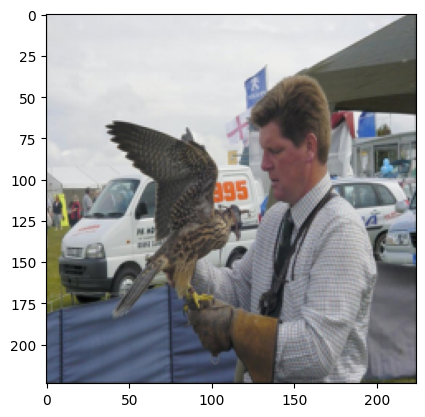

In [40]:
generate_captions_for_random_image(best_checkpoint_model)

two children are playing in the water 


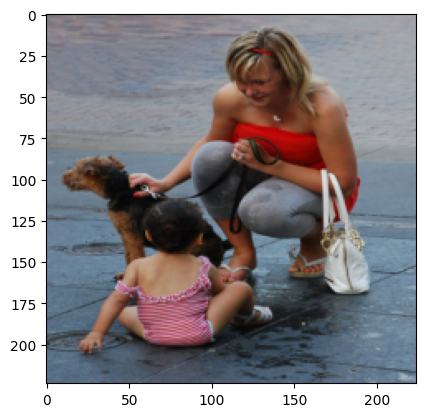

In [41]:
generate_captions_for_random_image(best_checkpoint_model)

group of people are walking in the snow 


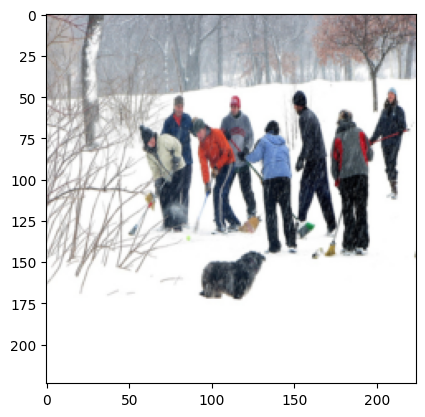

In [75]:
generate_captions_for_random_image(best_checkpoint_model)

man in black shirt and black hat is standing in front of building 


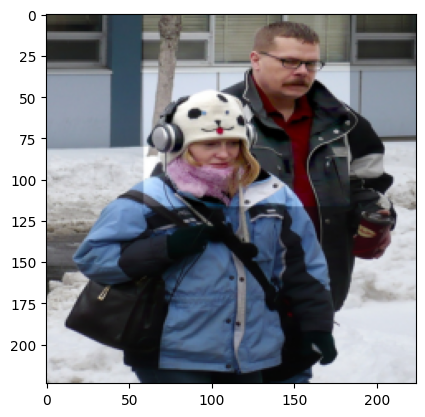

In [43]:
generate_captions_for_random_image(best_checkpoint_model)

dog is running through the water 


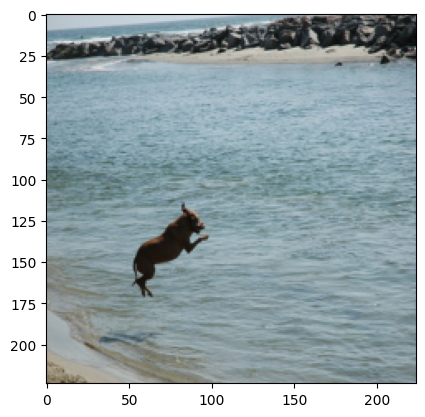

In [50]:
generate_captions_for_random_image(best_checkpoint_model)

dog is running through the water 


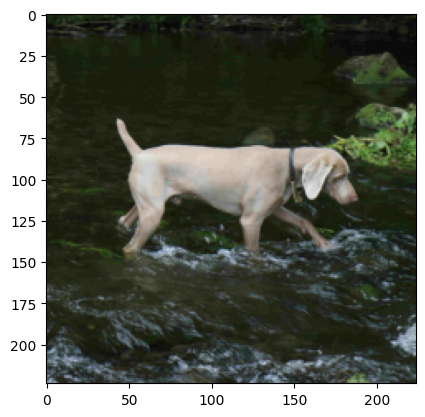

In [51]:
generate_captions_for_random_image(best_checkpoint_model)